# Capstone project: Improved Movies Recommender System

** Capstone project: *Improved Movies Recommender System*. ** I'll build a recommender system that'll go beyond the classic ones (only using ratings) and try to improve the system including other features as movie genre, movie description (NLP), movie cast/country/year, etc. For this I'll first build collaborative-filtering and content based models and then combine them in a hybrid model.

Also, as a side projects, I'll try to predict revenues and try some classification methods to see how they perform and clustering to seek potential alternative categories.

- [Data Overview](#data-overview) 
- [EDA](#EDA) 
- [Modelling](#modelling)
- [Technical Report](#report)

# Data Overview
<a id="data-overview"></a>

This section of the notebook includes a general overview of the datasets I'll be using for my Capstone and also some first stages of the data cleaning process (cleaning unfinished, I'll have to do more cleaning/data engineering as I advance with the project and get into the modelling phase). 

**The data comes from the famous MovieLens dataset, which was extracted from the MovieLens webpage by GroupLens Research from the Department of Computer Science and Engineering at the University of Minnesota Twin Cities.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import surprise as sur
from surprise import Reader, Dataset, SVD, evaluate
import warnings; warnings.simplefilter('ignore')

plt.style.use('ggplot')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 1000)

In [135]:
credits = pd.read_csv('/Users/luisfernandodecol/Documents/DSI_GA/DSI/DSI7-Example/DSI7-lessons/projects/project-capstone/Movies/movies-dataset/the-movies-dataset/credits.csv', low_memory=False)
keywords = pd.read_csv('/Users/luisfernandodecol/Documents/DSI_GA/DSI/DSI7-Example/DSI7-lessons/projects/project-capstone/Movies/movies-dataset/the-movies-dataset/keywords.csv', low_memory=False)
links = pd.read_csv('/Users/luisfernandodecol/Documents/DSI_GA/DSI/DSI7-Example/DSI7-lessons/projects/project-capstone/Movies/movies-dataset/the-movies-dataset/links.csv', low_memory=False)
#movies_metadata = pd.read_csv('/Users/luisfernandodecol/Documents/DSI_GA/DSI/DSI7-Example/DSI7-lessons/projects/project-capstone/Movies/movies-dataset/the-movies-dataset/movies_metadata.csv', low_memory=False)
ratings = pd.read_csv('/Users/luisfernandodecol/Documents/DSI_GA/DSI/DSI7-Example/DSI7-lessons/projects/project-capstone/Movies/movies-dataset/the-movies-dataset/ratings.csv', low_memory=False)

## I haven't read the movies_metadata so I don't have to do all the cleaning each time I open the notebook, 
## instead I have saved the clean version and I'll open it further down.


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


#### Let's take a look at the head of each dataframe to get an idea of what they include:

In [55]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}, {'cast_id': 15, 'character': 'Buzz Lightyear (voice)', 'credit_id': '52fe4284c3a36847f8024f99', 'gender': 2, 'id': 12898, 'name': 'Tim Allen', 'order': 1, 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}, {'cast_id': 16, 'character': 'Mr. Potato Head (voice)', 'credit_id': '52fe4284c3a36847f8024f9d', 'gender': 2, 'id': 7167, 'name': 'Don Rickles', 'order': 2, 'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'}, {'cast_id': 17, 'character': 'Slinky Dog (voice)', 'credit_id': '52fe4284c3a36847f8024fa1', 'gender': 2, 'id': 12899, 'name': 'Jim Varney', 'order': 3, 'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'}, {'cast_id': 18, 'character': 'Rex (voice)', 'credit_id': '52fe4284c3a36847f8024fa5', 'gender': 2, 'id': 12900, 'name': 'Wallace Shawn', 'order': 4, 'profile_path': '/oGE6JqPP2x...","[{'credit_id': '52fe4284c3a36847f8024f49', 'department': 'Directing', 'gender': 2, 'id': 7879, 'job': 'Director', 'name': 'John Lasseter', 'profile_path': '/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg'}, {'credit_id': '52fe4284c3a36847f8024f4f', 'department': 'Writing', 'gender': 2, 'id': 12891, 'job': 'Screenplay', 'name': 'Joss Whedon', 'profile_path': '/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg'}, {'credit_id': '52fe4284c3a36847f8024f55', 'department': 'Writing', 'gender': 2, 'id': 7, 'job': 'Screenplay', 'name': 'Andrew Stanton', 'profile_path': '/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg'}, {'credit_id': '52fe4284c3a36847f8024f5b', 'department': 'Writing', 'gender': 2, 'id': 12892, 'job': 'Screenplay', 'name': 'Joel Cohen', 'profile_path': '/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg'}, {'credit_id': '52fe4284c3a36847f8024f61', 'department': 'Writing', 'gender': 0, 'id': 12893, 'job': 'Screenplay', 'name': 'Alec Sokolow', 'profile_path': '/v79vlRYi94BZUQnkkyznbGUZLjT.jpg'}, {'credit_id': '52fe4284c3a36847f8024f67', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', 'credit_id': '52fe44bfc3a36847f80a7c73', 'gender': 2, 'id': 2157, 'name': 'Robin Williams', 'order': 0, 'profile_path': '/sojtJyIV3lkUeThD7A2oHNm8183.jpg'}, {'cast_id': 8, 'character': 'Samuel Alan Parrish / Van Pelt', 'credit_id': '52fe44bfc3a36847f80a7c99', 'gender': 2, 'id': 8537, 'name': 'Jonathan Hyde', 'order': 1, 'profile_path': '/7il5D76vx6QVRVlpVvBPEC40MBi.jpg'}, {'cast_id': 2, 'character': 'Judy Sheperd', 'credit_id': '52fe44bfc3a36847f80a7c77', 'gender': 1, 'id': 205, 'name': 'Kirsten Dunst', 'order': 2, 'profile_path': '/wBXvh6PJd0IUVNpvatPC1kzuHtm.jpg'}, {'cast_id': 24, 'character': 'Peter Shepherd', 'credit_id': '52fe44c0c3a36847f80a7ce7', 'gender': 0, 'id': 145151, 'name': 'Bradley Pierce', 'order': 3, 'profile_path': '/j6iW0vVA23GQniAPSYI6mi4hiEW.jpg'}, {'cast_id': 10, 'character': 'Sarah Whittle', 'credit_id': '52fe44bfc3a36847f80a7c9d', 'gender': 1, 'id': 5149, 'name': 'Bonnie Hunt', 'order': 4, 'profile_path': '/7spiVQ...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'department': 'Production', 'gender': 2, 'id': 511, 'job': 'Executive Producer', 'name': 'Larry J. Franco', 'profile_path': None}, {'credit_id': '52fe44bfc3a36847f80a7c89', 'department': 'Writing', 'gender': 2, 'id': 876, 'job': 'Screenplay', 'name': 'Jonathan Hensleigh', 'profile_path': '/l1c4UFD3g0HVWj5f0CxXAvMAGiT.jpg'}, {'credit_id': '52fe44bfc3a36847f80a7cdd', 'department': 'Sound', 'gender': 2, 'id': 1729, 'job': 'Original Music Composer', 'name': 'James Horner', 'profile_path': '/oLOtXxXsYk8X4qq0ud4xVypXudi.jpg'}, {'credit_id': '52fe44bfc3a36847f80a7c7d', 'department': 'Directing', 'gender': 2, 'id': 4945, 'job': 'Director', 'name': 'Joe Johnston', 'profile_path': '/fok4jaO62v5IP6hkpaaAcXuw2H.jpg'}, {'credit_id': '52fe44bfc3a36847f80a7cd7', 'department': 'Editing', 'gender': 2, 'id': 4951, 'job': 'Editor', 'name': 'Robert Dalva', 'profile_path': None}, {'credit_id': '573523bec3a368025100062c', 'department': 

In [56]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 9713, 'name': 'friends'}, {'id': 9823, 'name': 'rivalry'}, {'id': 165503, 'name': 'boy next door'}, {'id': 170722, 'name': 'new toy'}, {'id': 187065, 'name': 'toy comes to life'}]"
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 10941, 'name': 'disappearance'}, {'id': 15101, 'name': ""based on children's book""}, {'id': 33467, 'name': 'new home'}, {'id': 158086, 'name': 'recluse'}, {'id': 158091, 'name': 'giant insect'}]"
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392, 'name': 'best friend'}, {'id': 179431, 'name': 'duringcreditsstinger'}, {'id': 208510, 'name': 'old men'}]"
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id': 10131, 'name': 'interracial relationship'}, {'id': 14768, 'name': 'single mother'}, {'id': 15160, 'name': 'divorce'}, {'id': 33455, 'name': 'chick flick'}]"
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'name': 'midlife crisis'}, {'id': 2246, 'name': 'confidence'}, {'id': 4995, 'name': 'aging'}, {'id': 5600, 'name': 'daughter'}, {'id': 10707, 'name': 'mother daughter relationship'}, {'id': 13149, 'name': 'pregnancy'}, {'id': 33358, 'name': 'contraception'}, {'id': 170521, 'name': 'gynecologist'}]"


In [57]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.00
1,2,113497,"8,844.00"
2,3,113228,"15,602.00"
3,4,114885,"31,357.00"
4,5,113041,"11,862.00"


In [58]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.00,1425941529
1,1,147,4.50,1425942435
2,1,858,5.00,1425941523
3,1,1221,5.00,1425941546
4,1,1246,5.00,1425941556


In [13]:
movies_metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]",NaN,8844,tt0113497,en,Jumanji,"When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.",17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'name': 'Teitler Film', 'id': 2550}, {'name': 'Interscope Communications', 'id': 10201}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'fr', 'name': 'Français'}]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collection', 'poster_path': '/nLvUdqgPgm3F85NMCii9gVFUcet.jpg', 'backdrop_path': '/hypTnLot2z8wpFS7qwsQHW1uV8u.jpg'}",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]",NaN,15602,tt0113228,en,Grumpier Old Men,"A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in seafood than she is in cooking up a hot time with Max.",11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name': 'Lancaster Gate', 'id': 19464}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for Love.,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the women are holding their breath, waiting for the elusive ""good man"" to break a string of less-than-stellar lovers. Friends and confidants Vannah, Bernie, Glo and Robin talk it all out, determined to find a better way to breathe.",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,"[{'name': 'Twentieth Century Fox Film Corporation', 'id': 306}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself... and never let you forget it.,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Collection', 'poster_path': '/nts4iOmNnq7GNicycMJ9pSAn204.jpg'

#### I'll create some data dictionaries to understand what each variable means.

In [60]:
credits_dict = {'cast':'Information about the cast of each movie (cast id, character, gender, actor name).',
                'crew':'Information about the crew involved on the production of the movie.', 
                'id':'Movie id (tmdb id)'}
credits_datadict = pd.DataFrame.from_dict(credits_dict, orient='index', columns=['Description'])
credits_datadict

,Description
cast,"Information about the cast of each movie (cast id, character, gender, actor name)."
crew,Information about the crew involved on the production of the movie.
id,Movie id (tmdb id)


In [61]:
keywords_dict = {'id':'Movie id (tmdb id)', 
                 'keywords':'List of dictionaries containing each a keyword that identifies the movie, along with an id for that keyword. Usually between 3 and 10.'}
keywords_datadict = pd.DataFrame.from_dict(keywords_dict, orient='index', columns=['Description'])
keywords_datadict

,Description
id,Movie id (tmdb id)
keywords,"List of dictionaries containing each a keyword that identifies the movie, along with an id for that keyword. Usually between 3 and 10."


In [264]:
links_dict = {'movieId':"Movie id from MovieLens", 
              'imdbId':'Movie id from the IMDb, present in some of the other datasets, will be used to concatenate dataframes',
              'tmdbId':'Movie id from TMDb, present in some of the other datasets, will be used to concatenate dataframes'}
links_datadict = pd.DataFrame.from_dict(links_dict, orient='index', columns=['Description'])
links_datadict

,Description
movieId,Movie id from MovieLens
imdbId,"Movie id from the IMDb, present in some of the other datasets, will be used to concatenate dataframes"
tmdbId,"Movie id from TMDb, present in some of the other datasets, will be used to concatenate dataframes"


In [265]:
ratings_dict = {'userId':'id identifying the user that gives a rating to a movie.', 
                'movieId':'MovieLens id identifying the movie rated by a user.',
                'rating':'Rating (1-5) given to the movie by the user.', 
                'timestamp':'Timestamp at which the rating was given, if used can be converted to a datetime object.'}
ratings_datadict = pd.DataFrame.from_dict(ratings_dict, orient='index', columns=['Description'])
ratings_datadict

,Description
userId,id identifying the user that gives a rating to a movie.
movieId,MovieLens id identifying the movie rated by a user.
rating,Rating (1-5) given to the movie by the user.
timestamp,"Timestamp at which the rating was given, if used can be converted to a datetime object."


In [64]:
movies_dict = {'adult':'Indicates if the movie is only for adults, unsuitable for childrens.', 
               'belongs_to_collection':'If the movie is part of a collection of movies, indicates the name and id of the collection.',
               'budget':'Budget that the production had to make the movie.', 
               'genres':'Movies genres to which the movie belongs.', 'homepage':'Webpage of the movie.', 
               'id':'TMDb id of the movie', 'imdb_id':'IMDb id of the movie', 
               'original_language':'Original language of the movie.', 'original_title':'Original title of the movie.', 
               'overview':'Summary of the movie plot', 'popularity':'Popularity score for the movie.', 
               'poster_path':'Path to the poster of the movie.', 
               'production_companies':'Companies involved in the production of the movie', 
               'release_date':'Release date of the movie', 'revenue':'Revenue in US$ the movie made.', 
               'runtime':'Duration in minutes of the movie.', 'spoken_languages':'Languages spoken in the movie.', 
               'status':"Status of the movie ('Released', nan, 'Rumored', 'Post Production', 'In Production', 'Planned', 'Canceled').",
               'tagline':'Short tagline description of the movie.', 
               'Title':'English title of the movie (in case original title is in other language).',
               'video':"Don't know, won't be used (most of them are 'False').",
               'vote_average':'Average rating given by users to the movie (0-10).', 
               'vote_count':'Count of ratings given by users to the movie.'}
movies_datadict = pd.DataFrame.from_dict(movies_dict, orient='index', columns=['Description'])
movies_datadict

,Description
adult,"Indicates if the movie is only for adults, unsuitable for childrens."
belongs_to_collection,"If the movie is part of a collection of movies, indicates the name and id of the collection."
budget,Budget that the production had to make the movie.
genres,Movies genres to which the movie belongs.
homepage,Webpage of the movie.
id,TMDb id of the movie
imdb_id,IMDb id of the movie
original_language,Original language of the movie.
original_title,Original title of the movie.
overview,Summary of the movie plot


Now I'll check if each column is of the data type it should be and if it has missing values.

In [65]:
datasets = [credits, keywords, links, movies_metadata, ratings]
def informer(list):
    for e in list:
        print('=============================================================================================================')
        print(e.info())
        print(e.shape)
        print(e.head(1))
        print('\n')

In [66]:
informer(datasets)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
cast    45476 non-null object
crew    45476 non-null object
id      45476 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.0+ MB
None
(45476, 3)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

It seems that movies_metadata may have some things to improve (id is object should be int, imdb_id could be withouth the 'tt', popularity as int, releas_date as datetime or split into year and month, adult as binary, collection and productions cleaned). Also, I can remove some columns that won't be used.

In [72]:
movies_metadata.adult.unique()

array(['False', 'True', ' - Written by Ørnås',
       ' Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.',
       ' Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.'],
      dtype=object)

In [136]:
movies_metadata.adult = [0 if x=='False' else 1 for x in movies_metadata.adult]

In [74]:
movies_metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,0,"{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-10-30,"373,554,033.00",81.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.70,"5,415.00"
1,0,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]",NaN,8844,tt0113497,en,Jumanji,"When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.",17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'name': 'Teitler Film', 'id': 2550}, {'name': 'Interscope Communications', 'id': 10201}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-12-15,"262,797,249.00",104.00,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'fr', 'name': 'Français'}]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.90,"2,413.00"
2,0,"{'id': 119050, 'name': 'Grumpy Old Men Collection', 'poster_path': '/nLvUdqgPgm3F85NMCii9gVFUcet.jpg', 'backdrop_path': '/hypTnLot2z8wpFS7qwsQHW1uV8u.jpg'}",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]",NaN,15602,tt0113228,en,Grumpier Old Men,"A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in seafood than she is in cooking up a hot time with Max.",11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name': 'Lancaster Gate', 'id': 19464}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-12-22,0.00,101.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for Love.,Grumpier Old Men,False,6.50,92.00
3,0,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the women are holding their breath, waiting for the elusive ""good man"" to break a string of less-than-stellar lovers. Friends and confidants Vannah, Bernie, Glo and Robin talk it all out, determined to find a better way to breathe.",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,"[{'name': 'Twentieth Century Fox Film Corporation', 'id': 306}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-12-22,"81,452,156.00",127.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself... and never let you forget it.,Waiting to Exhale,False,6.10,34.00
4,0,"{'id': 96871, 'name': 'Father of the Bride Collection', 'poster_path': '/nts4iOmNnq7GNicycM

In [75]:
movies_metadata.video.value_counts()

False    45367
True        93
Name: video, dtype: int64

In [137]:
movies_metadata.drop(columns=['homepage','poster_path','production_companies','video', 'spoken_languages'], inplace=True)

In [77]:
[x for x in movies_metadata.id if '-' in x]

['1997-08-20', '2012-09-29', '2014-01-01']

In [78]:
movies_metadata.shape

(45466, 19)

In [138]:
movies_metadata.drop(index=movies_metadata[movies_metadata.id == '1997-08-20'].index, inplace=True)

In [139]:
movies_metadata.drop(index=movies_metadata[movies_metadata.id == '2012-09-29'].index, inplace=True)

In [140]:
movies_metadata.drop(index=movies_metadata[movies_metadata.id == '2014-01-01'].index, inplace=True)

In [141]:
movies_metadata.id = movies_metadata.id.map(lambda x: int(x))

In [142]:
movies_metadata.imdb_id.fillna('tt0', inplace=True)

In [143]:
movies_metadata.imdb_id = movies_metadata.imdb_id.map(lambda x: int(x.replace('tt','')))

In [144]:
movies_metadata.popularity.fillna(0, inplace=True)

In [145]:
movies_metadata.popularity = movies_metadata.popularity.map(lambda x: float(x))

In [559]:
movies_metadata.release_date[:5]

0    1995-10-30
1    1995-12-15
2    1995-12-22
3    1995-12-22
4    1995-02-10
Name: release_date, dtype: object

In [560]:
movies_metadata.belongs_to_collection.fillna(0, inplace=True)

In [90]:
movies_metadata.shape

(45463, 20)

In [ ]:
#Let's get only the code of the collections for the movies that belong to a collection:
for i,e in tqdm_notebook(enumerate(movies_metadata.belongs_to_collection)):
    if type(e)==str:
        movies_metadata.belongs_to_collection.iloc[i]=int(e.split(',')[0].split(': ')[1])
    else:
        movies_metadata.belongs_to_collection.iloc[i]=e

In [92]:
movies_metadata.sort_values('vote_average', ascending=False).head()

,adult,belongs_to_collection,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,production_countries,revenue,runtime,status,tagline,title,vote_average,vote_count,release_year,release_month
21642,0,0,0,"[{'id': 99, 'name': 'Documentary'}]",320849,886500,en,Ice Age Columbus: Who Were the First Americans?,"Firmly rooted in the latest scientific discoveries, this docudrama explores the theory that Europeans came to America much earlier than previously thought. New archaeological data and DNA research touch on an ice bridge that spanned the Atlantic. Follow the fascinating adventures of a Stone Age family as they travel from France and settle in America -- about 17,000 years before Columbus was even born.",0.04,[],0.00,0.00,Released,NaN,Ice Age Columbus: Who Were the First Americans?,10.00,1.00,1995,10
15710,0,0,0,"[{'id': 99, 'name': 'Documentary'}]",96451,1587373,en,If God Is Willing and da Creek Don't Rise,"In 2006, director Spike Lee created an astonishing record of the cataclysmic effects of Hurricane Katrina on the city of New Orleans with his epic award-winning documentary, When the Levees Broke. Five years later, Lee returns to New Orleans, to see how the ambitious plans to reinvent the Crescent City were playing out. He finds a patchwork of hope and heartache just as a new disaster unfolds. The four-hour documentary is a continuation of the heart-rending story of destruction and rebirth of America's most unique city.",0.11,"[{'iso_3166_1': 'US', 'name': 'United States of America'}]",0.00,255.00,Released,NaN,If God Is Willing and da Creek Don't Rise,10.00,1.00,1995,10
22396,0,0,0,"[{'id': 99, 'name': 'Documentary'}]",72123,1341746,en,Meat the Truth,"Meat the Truth is a high-profile documentary which forms an addendum to earlier films on climate change. Although such films have succeeded in drawing public attention to the issue of global warming, they have repeatedly ignored one of the most important causes of climate change: the intensive livestock production. Meat the Truth draws attention to this by demonstrating that livestock farming generates more greenhouse gas emissions worldwide than all cars, lorries, trains, boats and planes added together.",0.09,[],0.00,74.00,Released,NaN,Meat the Truth,10.00,1.00,1995,10
22395,0,0,0,"[{'id': 99, 'name': 'Documentary'}]",230864,3011874,en,Marvin Hamlisch: What He Did For Love,"When Marvin Hamlisch passed away in August 2012 the worlds of music, theatre and cinema lost a talent the likes of which we may never see again. Seemingly destined for greatness, Hamlisch was accepted into New York’s Juilliard School as a 6-year-old musical prodigy and rapidly developed into a phenomenon. With instantly classic hits ‘The Way We Were’ and ‘Nobody Does It Better’ and scores for Hollywood films such as The Swimmer, The Sting and Sophie’s Choice and the Broadway juggernaut A Chorus Line; Hamlisch became the go-to composer for film and Broadway producers and a prominent presence on the international Concert Hall circuit. His streak was staggering, vast, unprecedented and glorious, by the age of 31 Hamlisch had won 4 Grammys, an Emmy, 3 Oscars, a Tony and a Pulitzer prize: success that burned so bright, it proved impossible to match.",0.37,"[{'iso_3166_1': 'US', 'name': 'United States of America'}, {'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",0.00,82.00,Released,NaN,Marvin Hamlisch: What He Did For Love,10.00,1.00,1995,10
35343,0,0,300000,"[{'id': 35, 'name': 'Comedy'}, {'id': 99, 'name': 'Documentary'}, {'id': 10402, 'name': 'Music'}, {'id': 10770, 'name': 'TV Movie'}]",140595,308213,en,Elaine Stritch: At Liberty,Judy at the Palace. Sinatra at Carnegie Hall. Streisand at the Garden. Stritch on Broadway. Legendary performances come along so rarely.,0.09,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}, {'iso_3166_1': 'US', 'name': 'United States of America'}]",0.00,140.00,Released,Legendary performances come along so rarely.,Elaine Stritch: At Liberty,10.00,1.00,199

In [93]:
movies_metadata.sort_values('vote_average', ascending=True).head()

,adult,belongs_to_collection,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,production_countries,revenue,runtime,status,tagline,title,vote_average,vote_count,release_year,release_month
45465,0,0,0,[],461257,6980792,en,Queerama,"50 years after decriminalisation of homosexuality in the UK, director Daisy Asquith mines the jewels of the BFI archive to take us into the relationships, desires, fears and expressions of gay men and women in the 20th century.",0.16,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",0.00,75.00,Released,NaN,Queerama,0.00,0.00,1995,10
24507,0,38451,0,"[{'id': 9648, 'name': 'Mystery'}]",413669,23881,en,Charlie Chan's Greatest Case,Charlie Chan's Greatest Case,0.01,"[{'iso_3166_1': 'US', 'name': 'United States of America'}]",0.00,70.00,Released,NaN,Charlie Chan's Greatest Case,0.00,0.00,1995,10
24506,0,0,0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name': 'Thriller'}]",3576,34570,en,Calling Dr. Gillespie,Dr. Gillespie is called in to investigate when a young man suffering from mental problems disappears on a killing spree.,0.03,"[{'iso_3166_1': 'US', 'name': 'United States of America'}]",0.00,89.00,Released,NaN,Calling Dr. Gillespie,0.00,0.00,1995,10
24498,0,0,0,"[{'id': 99, 'name': 'Documentary'}]",212846,3091380,en,Mission Congo,A documentary that examines whether a charity organized by Pat Robertson to aid Rwandan genocide refugees was a front for diamond mining.,0.01,"[{'iso_3166_1': 'US', 'name': 'United States of America'}]",0.00,68.00,Released,NaN,Mission Congo,0.00,0.00,1995,10
24497,0,0,0,"[{'id': 35, 'name': 'Comedy'}]",208286,2621742,en,Crimes Against Humanity,"After cheating on her mean boyfriend, Lewis, Brownie is hospitalized by a series of severe accidents. Instead of visiting her in the hospital, Lewis (assistant to the Dean of the local university) helps investigate two professors suspected of sleeping with students.",0.02,"[{'iso_3166_1': 'US', 'name': 'United States of America'}]",0.00,77.00,Released,NaN,Crimes Against Humanity,0.00,0.00,1995,10


Some movie ratings aren't a good reference as they've only been ranked once. This won't be the problem as these are not the ratings that I'll use (but I'll have to deal with this in the 'ratings' dataset). 

In [94]:
movies_metadata.genres.nunique()

4066

The 'genres' column can be cleaned, we can extract the genres and create dummies.

In [147]:
import ast
categs = []
for i in tqdm_notebook(range(len(movies_metadata.genres.unique()))):
    for a in range(len(ast.literal_eval(movies_metadata.genres.unique()[i]))):
        if ast.literal_eval(movies_metadata.genres.unique()[i])[a].get('name') not in categs:
            categs.append(ast.literal_eval(movies_metadata.genres.unique()[i])[a].get('name'))
            
            

In [148]:
print(categs)

['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western', 'TV Movie']


In [150]:
for e in categs:
    movies_metadata[e] = 0

In [ ]:
for i in tqdm_notebook(range(len(movies_metadata))):
    for a in range(len(ast.literal_eval(movies_metadata.genres[i]))):
        movies_metadata[ast.literal_eval(movies_metadata.genres[i])[a].get('name')][i] = 1

For now I'll save this partially cleaned movies_metadata as a new csv so, when using it later, I don't have to do all the cleaning again.

In [86]:
#movies_metadata.to_csv('movies_metadata_cleaned.csv', index=False)

In [155]:
movies_metadata = pd.read_csv('./movies_metadata_cleaned.csv', low_memory=False)

I've left some columns that could be cleaned but I won't do it now as I don't know if I'll use them. Now let's check the ids from all the datasets to see how we could merge them. First I'll put together all the movies info and then add that info to the users ratings.

Before doing the merges, I have to look into the ratings df and filter it to only keep the movies and users that have a good amount of ratings (A movie only rated by one user isn't useful, the same for a user who has only rated one movie).

In [101]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.00,1425941529
1,1,147,4.50,1425942435
2,1,858,5.00,1425941523
3,1,1221,5.00,1425941546
4,1,1246,5.00,1425941556


In [102]:
ratings.shape

(26024289, 4)

In [103]:
ratings.userId.nunique()

270896

In [104]:
ratings.movieId.nunique()

45115

In [243]:
ratings.userId.value_counts()[:10]

45811     18276
8659       9279
270123     7638
179792     7515
228291     7410
243443     6320
98415      6094
229879     6024
98787      5814
172224     5701
Name: userId, dtype: int64

In [244]:
ratings.movieId.value_counts()[:10]

356     91921
318     91082
296     87901
593     84078
2571    77960
260     77045
480     74355
527     67662
110     66512
1       66008
Name: movieId, dtype: int64

In [107]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.00,1425941529
1,1,147,4.50,1425942435
2,1,858,5.00,1425941523
3,1,1221,5.00,1425941546
4,1,1246,5.00,1425941556


Let's create dataframes with the count of users and movies, to see how many ratings each user and movie has.

In [11]:
movies_count = pd.DataFrame(ratings.movieId.value_counts()).reset_index().rename(columns={'index':'movieId',
                                                                                          'movieId':'count'})
users_count = pd.DataFrame(ratings.userId.value_counts()).reset_index().rename(columns={'index':'userId',
                                                                                          'userId':'count'})

In [109]:
movies_count.head()

,movieId,count
0,356,91921
1,318,91082
2,296,87901
3,593,84078
4,2571,77960


In [110]:
users_count.tail()

,userId,count
270891,114594,1
270892,111195,1
270893,266491,1
270894,45691,1
270895,177573,1


In [111]:
movies_count.describe()

,movieId,count
count,"45,115.00","45,115.00"
mean,"95,927.99",576.84
std,"57,367.31","3,037.38"
min,1.00,1.00
25%,"47,724.00",2.00
50%,"107,658.00",8.00
75%,"144,929.00",69.00
max,"176,275.00","91,921.00"


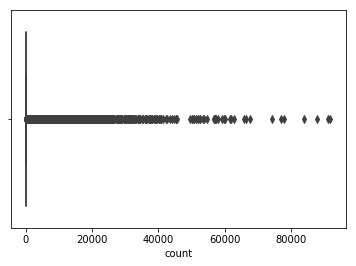

In [112]:
sns.boxplot(x=movies_count['count'])

Looking at the quartiles and at the boxplot we can see that most of the movies have been rated few times, let's look at this in a more practical way, as in this case we can't use a rule such as 'Choose the top 50% of the data', as it would still be a low ammount of ratings.

In [113]:
for i in [0,1,2,5,10,20,30,40,50,100,150,200,500,1000]:
    print(len(movies_count[movies_count['count']>i]),'movies have received more than',i,'ratings')


45115 movies have received more than 0 ratings
37456 movies have received more than 1 ratings
32487 movies have received more than 2 ratings
25450 movies have received more than 5 ratings
20589 movies have received more than 10 ratings
16544 movies have received more than 20 ratings
14587 movies have received more than 30 ratings
13396 movies have received more than 40 ratings
12441 movies have received more than 50 ratings
9946 movies have received more than 100 ratings
8661 movies have received more than 150 ratings
7766 movies have received more than 200 ratings
5291 movies have received more than 500 ratings
3744 movies have received more than 1000 ratings


In [114]:
users_count.describe()

,userId,count
count,"270,896.00","270,896.00"
mean,"135,448.50",96.07
std,"78,201.08",205.72
min,1.00,1.00
25%,"67,724.75",15.00
50%,"135,448.50",30.00
75%,"203,172.25",93.00
max,"270,896.00","18,276.00"


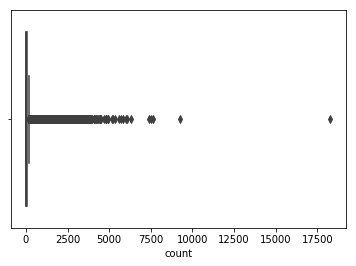

In [115]:
sns.boxplot(x=users_count['count'])

In [116]:
for i in [0,1,2,5,10,20,30,40,50,100,150,200,500,1000]:
    print(len(users_count[users_count['count']>i]),'users have given more than',i,'ratings')


270896 users have given more than 0 ratings
265812 users have given more than 1 ratings
262203 users have given more than 2 ratings
248783 users have given more than 5 ratings
227108 users have given more than 10 ratings
161497 users have given more than 20 ratings
134092 users have given more than 30 ratings
116000 users have given more than 40 ratings
102379 users have given more than 50 ratings
63577 users have given more than 100 ratings
43725 users have given more than 150 ratings
32811 users have given more than 200 ratings
9452 users have given more than 500 ratings
2502 users have given more than 1000 ratings


It is hard to choose a treshold for the amount of ratings, so for now I'll choose 49 for both movies and users (so I only keep movies that have been rated 50 times or more and users that have given 50 or more ratings. For this I'll add columns with movies_count and users_count and then filter them to only keep the ones wanted.

In [12]:
new_ratings = pd.merge(ratings, users_count, on='userId', how='inner', sort=False)

In [13]:
new_ratings.rename(columns={'count':'users_count'}, inplace=True)

In [14]:
new_ratings2 = pd.merge(new_ratings, movies_count, on='movieId', how='inner', sort=False)

In [15]:
new_ratings2.rename(columns={'count':'movies_count'}, inplace=True)

In [121]:
new_ratings2.head()

,userId,movieId,rating,timestamp,users_count,movies_count
0,1,110,1.00,1425941529,27,66512
1,11,110,3.50,1231676989,227,66512
2,22,110,5.00,1111937009,38,66512
3,24,110,5.00,979870012,634,66512
4,29,110,3.00,1044020005,56,66512


In [122]:
ratings.shape

(26024289, 4)

In [16]:
new_ratings3 = new_ratings2[new_ratings2.users_count>49]

In [17]:
filtered_ratings = new_ratings3[new_ratings3.movies_count>49]

In [125]:
filtered_ratings.head()

,userId,movieId,rating,timestamp,users_count,movies_count
1,11,110,3.50,1231676989,227,66512
3,24,110,5.00,979870012,634,66512
4,29,110,3.00,1044020005,56,66512
5,30,110,5.00,967986311,120,66512
7,34,110,5.00,1498760804,269,66512


Now that I've filtered the original ratings with the users and movies ratings counts from the original ratings, the number of ratings given by a user or received by a movie in this new dataframe has changed (because I've removed observations), so I have to remove the counts columns and redo the process with the new dataframe to get new ones with the correct values.

In [18]:
filtered_ratings.drop(columns=['users_count', 'movies_count'], inplace=True)

In [19]:
movies_count2 = pd.DataFrame(filtered_ratings.movieId.value_counts()).reset_index().rename(columns={'index':'movieId',
                                                                                          'movieId':'count'})
users_count2 = pd.DataFrame(filtered_ratings.userId.value_counts()).reset_index().rename(columns={'index':'userId',
                                                                                          'userId':'count'})

In [20]:
filtered_ratings = pd.merge(filtered_ratings, users_count2, on='userId', how='inner', sort=False)

In [21]:
filtered_ratings.rename(columns={'count':'users_count'}, inplace=True)

In [22]:
filtered_ratings = pd.merge(filtered_ratings, movies_count2, on='movieId', how='inner', sort=False)

In [23]:
filtered_ratings.rename(columns={'count':'movies_count'}, inplace=True)

Also, as I've removed some elements, there may be some others that no longer pass the threshold (50). For example, let's imagine a user "X" that before, on the original ratings, had given 50 ratings (so it passed the threshold) but one of the movies he rated only had 10 ratings so it didn't pass the threshold and that rating by the user "X" is no longer taken into account, so in the new dataframe the user "X" now only has 49 ratings and now he doesn't pass the threshold. This is why I'll filter the counts again.

In [24]:
filtered_ratings = filtered_ratings[filtered_ratings.users_count>49]

In [25]:
filtered_ratings = filtered_ratings[filtered_ratings.movies_count>49]

Just to confirm that everything is fine (no upper outliers nor counts smaller than 50), let's take a last look.

In [27]:
np.sort(filtered_ratings.users_count.unique())[::-1]

array([7435, 6962, 6873, ...,   52,   51,   50])

In [28]:
np.sort(filtered_ratings.movies_count.unique())[::-1]

array([65614, 63909, 61132, ...,    52,    51,    50])

In [251]:
#filtered_ratings.to_csv('filtered_ratings.csv', index=False)

In [26]:
filtered_ratings = pd.read_csv('./filtered_ratings.csv', low_memory=False)

In [29]:
filtered_ratings.head()

,userId,movieId,rating,timestamp,users_count,movies_count
0,11,110,3.5,1231676989,226,50854
1,24,110,5.0,979870012,634,50854
2,29,110,3.0,1044020005,56,50854
3,30,110,5.0,967986311,120,50854
4,34,110,5.0,1498760804,269,50854


# EDA
<a id="EDA"></a>

The Exploratory Data Analysis will be a good complement to the Data Overview done in the previous section. The two datasets that I'll use are "filtered_ratings" (from where I'll get the ratings given by each user, the ratings received by each movie and the counts of those ratings) and "movies_metadata" (from where I'll get the movies info and some NLP on the movies overview to get wordclouds). Also, the main datafiles for the recommender system are these ones, one with the ratings information (base for the system) and other with movies information (which I'll try to use to improve the system); the other files (credits and keywords) are some extra information that I don't know yet if I'll use.

I expect to get two main things from this EDA: 
 - Get an idea of the ratings distribution and see if those distributions differ between movie categories.
 - See if the variables are within the 'expected' values to know if there is some extra cleaning needed.

**First I'll start with the ratings EDA (I've done some descriptive statistics above, but I'll just redo them). **

In [5]:
filtered_ratings.head(5)

,userId,movieId,rating,timestamp,users_count,movies_count
0,11,110,3.5,1231676989,226,50854
1,24,110,5.0,979870012,634,50854
2,29,110,3.0,1044020005,56,50854
3,30,110,5.0,967986311,120,50854
4,34,110,5.0,1498760804,269,50854


In [148]:
filtered_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22602200 entries, 0 to 22619022
Data columns (total 6 columns):
userId          int64
movieId         int64
rating          float64
timestamp       int64
users_count     int64
movies_count    int64
dtypes: float64(1), int64(5)
memory usage: 1.2 GB


In [149]:
filtered_ratings.isnull().sum()

userId          0
movieId         0
rating          0
timestamp       0
users_count     0
movies_count    0
dtype: int64

In [150]:
pd.options.display.float_format = '{:20,.2f}'.format
filtered_ratings.describe()

,userId,movieId,rating,timestamp,users_count,movies_count
count,"22,602,200.00","22,602,200.00","22,602,200.00","22,602,200.00","22,602,200.00","22,602,200.00"
mean,"134,949.26","15,786.95",3.52,"1,175,178,827.56",564.41,"13,229.43"
std,"78,127.08","30,303.84",1.05,"201,095,639.46",664.39,"13,628.57"
min,4.00,1.00,0.50,"789,652,004.00",50.00,50.00
25%,"67,187.00","1,175.00",3.00,"996,898,490.50",159.00,"3,011.00"
50%,"135,103.00","2,712.00",3.50,"1,151,852,912.50",341.00,"8,561.00"
75%,"202,481.00","6,711.00",4.00,"1,358,125,944.00",714.00,"18,807.00"
max,"270,896.00","174,585.00",5.00,"1,501,829,623.00","7,435.00","65,614.00"


In [151]:
print('Number of users: ', filtered_ratings.userId.nunique())
print('Number of movies: ', filtered_ratings.movieId.nunique())

Number of users:  103669
Number of movies:  12341


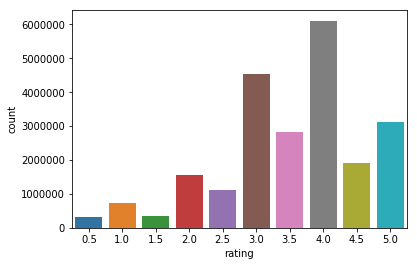

In [15]:
sns.countplot(x=filtered_ratings.rating,data=filtered_ratings)
# The ratings are left skewed, the mean is 3.52 and there are only few movies with less than 2.

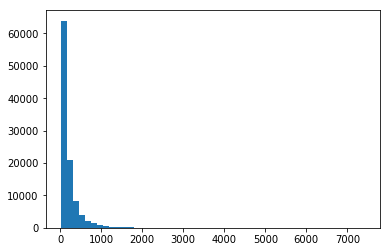

In [153]:
users_count2['count'].hist(bins=50, grid=False);
#the count of ratings given by each user is highly right skewed, few users have given more than 1,000 ratings.

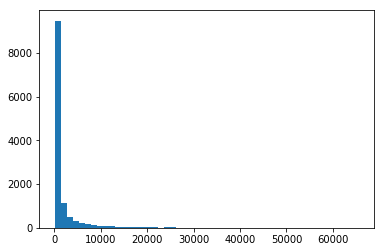

In [154]:
movies_count2['count'].hist(bins=50, grid=False);
# There is the same skew with the number of ratings received by each movie but the numbers are higher. Only few
# movies have more than 10,000 ratings.

After removing the users who have given less than 50 ratings and the movies that has less than 50 ratings I'm left with 103,669 different users and 12,341 different movies, that combined generate 22,6 millions of different user-movie rating combinations. The mean rating is 3.52, slightly above average but nothing unexpected.

The variables "movies_count2" (how many times each movie has been rated) and "users_count2" (how many rating each user has given) are highly skewed, most values are closer to 50. This is expected as the mean value for movies_count is 13,229 (on average, each movie from the dataset has been rated 13,229 times) and for usercount 564 (on average, each user has rated 564 different movies). This is because there are some few movies with much more ratings (probably the most famous ones, the first two are Forrest Gump and Pulp Fiction) and few users who have given many ratings. These "outliers" aren't bad for the model as they only provide more information, but still I'll check the users with the most ratings given to see if those values are "human possible".

Now for the movies_metadata, which has the movies information. I'll create a copy of this datafile and do some modifications for the EDA and add a columnt with the average rating of each movie from the filtered_ratings so I can plot the ratings for different movie categories.

In [155]:
movies_metadata.head()

,adult,belongs_to_collection,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,production_countries,revenue,runtime,status,tagline,title,vote_average,vote_count,release_year,release_month,Animation,Comedy,Family,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,History,Science Fiction,Mystery,War,Foreign,Music,Documentary,Western,TV Movie
0,0,10194,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]",862,114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",21.95,"[{'iso_3166_1': 'US', 'name': 'United States of America'}]","373,554,033.00",81.00,Released,NaN,Toy Story,7.70,"5,415.00",1995,10,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]",8844,113497,en,Jumanji,"When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.",17.02,"[{'iso_3166_1': 'US', 'name': 'United States of America'}]","262,797,249.00",104.00,Released,Roll the dice and unleash the excitement!,Jumanji,6.90,"2,413.00",1995,10,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,119050,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]",15602,113228,en,Grumpier Old Men,"A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in seafood than she is in cooking up a hot time with Max.",11.71,"[{'iso_3166_1': 'US', 'name': 'United States of America'}]",0.00,101.00,Released,Still Yelling. Still Fighting. Still Ready for Love.,Grumpier Old Men,6.50,92.00,1995,10,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]",31357,114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the women are holding their breath, waiting for the elusive ""good man"" to break a string of less-than-stellar lovers. Friends and confidants Vannah, Bernie, Glo and Robin talk it all out, determined to find a better way to breathe.",3.86,"[{'iso_3166_1': 'US', 'name': 'United States of America'}]","81,452,156.00",127.00,Released,Friends are the people who let you be yourself... and never let you forget it.,Waiting to Exhale,6.10,34.00,1995,10,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,96871,0,"[{'id': 35, 'name': 'Comedy'}]",11862,113041,en,Father of the Bride Part II,"Just when George Banks has recovered from his daughter's wedding, he receives the news that she's pregnant ... and that George's wife, Nina, is expecting too. He was planning on selling their home, but that's a plan that -- like George -- will have to change with the arrival of both a grandchild and a kid of his own.",8.39,"[{'iso_3166_1': 'US', 'name': 'United States of America'}]","76,578,911.00",106.00,Released,Just When His World Is Back To Normal... He's In For The Surprise Of His Life!,Father of the Bride Part II,5.70,173.00,1995,10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
movies_metadata_eda = movies_metadata.copy()

In [28]:
movies_metadata_eda = pd.merge(movies_metadata_eda, links, how='inner', left_on='id', right_on='tmdbId', sort=False)

In [29]:
movies_metadata_eda = pd.merge(movies_metadata_eda, movies_count2, how='inner', left_on='movieId', right_on='movieId', sort=False)


In [30]:
movies_metadata_eda = movies_metadata_eda[movies_metadata_eda['count']>49]

In [ ]:
movies_metadata_eda['rating'] = [filtered_ratings[filtered_ratings.movieId==x].rating.mean() for x in movies_metadata_eda.movieId]

In [ ]:
to_drop_eda = ['vote_average', 'vote_count']

I need to use the same ratings that I have on the filtered_ratings DataFrame, that's why I've added the mean ratings for each movie based on the ratings given by the users from filtered_ratings and dropped the vote_average column.

In [ ]:
movies_metadata_eda.drop(columns=to_drop_eda, inplace=True)

In [96]:
movies_metadata_eda.title.nunique()

11786

In [97]:
len(movies_metadata_eda.title)

12293

As noticed, there are some movies with the same title, so the release year will be added to the title to be able to differentiate them.

In [ ]:
movies_metadata_eda['year'] = pd.to_datetime(movies_metadata_eda['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [ ]:
movies_metadata_eda['full_title'] = movies_metadata_eda['title']+' '+movies_metadata_eda['year']

In [ ]:
movies_metadata_eda.head(2)

In [211]:
#movies_metadata_eda.to_csv('movies_metadata_eda.csv', index=False)

In [33]:
movies_metadata_eda = pd.read_csv('./movies_metadata_eda.csv', low_memory=False)

Now that I have the average rating for each movie added to the movies_metadata I can plot some interesting things such as the distribution of ratings for each movie categorie.

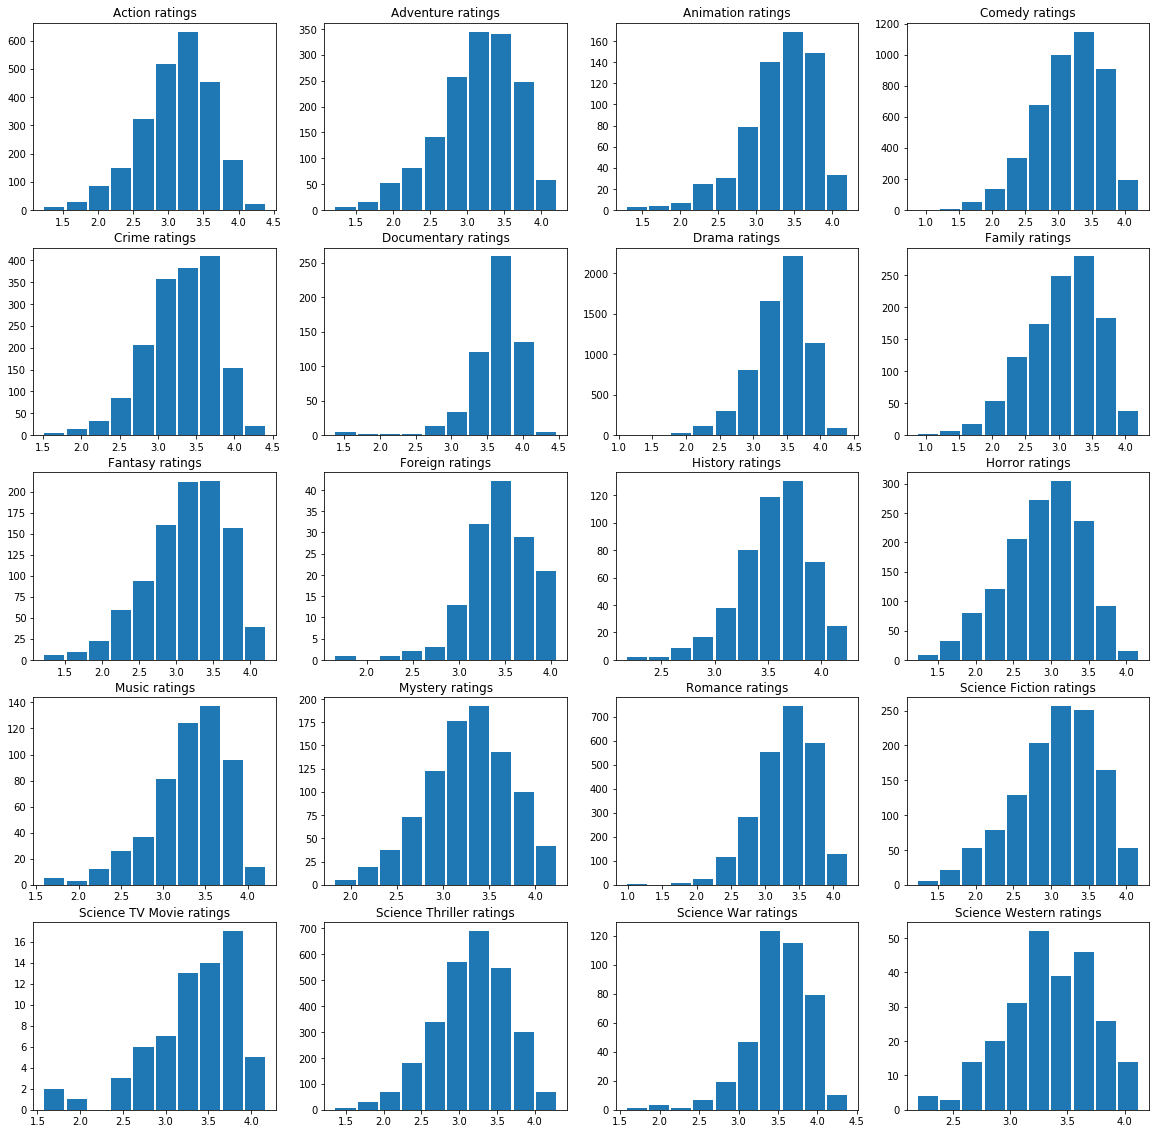

In [230]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20,20))

ax[0][0].hist(movies_metadata_eda[movies_metadata_eda.Action==1].rating, align='mid', bins=10, rwidth=0.9)
ax[0][0].set_title('Action ratings')

ax[0][1].hist(movies_metadata_eda[movies_metadata_eda.Adventure==1].rating, align='mid', bins=10, rwidth=0.9)
ax[0][1].set_title('Adventure ratings')

ax[0][2].hist(movies_metadata_eda[movies_metadata_eda.Animation==1].rating, align='mid', bins=10, rwidth=0.9)
ax[0][2].set_title('Animation ratings')

ax[0][3].hist(movies_metadata_eda[movies_metadata_eda.Comedy==1].rating, align='mid', bins=10, rwidth=0.9)
ax[0][3].set_title('Comedy ratings')

ax[1][0].hist(movies_metadata_eda[movies_metadata_eda.Crime==1].rating, align='mid', bins=10, rwidth=0.9)
ax[1][0].set_title('Crime ratings')

ax[1][1].hist(movies_metadata_eda[movies_metadata_eda.Documentary==1].rating, align='mid', bins=10, rwidth=0.9)
ax[1][1].set_title('Documentary ratings')

ax[1][2].hist(movies_metadata_eda[movies_metadata_eda.Drama==1].rating, align='mid', bins=10, rwidth=0.9)
ax[1][2].set_title('Drama ratings')

ax[1][3].hist(movies_metadata_eda[movies_metadata_eda.Family==1].rating, align='mid', bins=10, rwidth=0.9)
ax[1][3].set_title('Family ratings')

ax[2][0].hist(movies_metadata_eda[movies_metadata_eda.Fantasy==1].rating, align='mid', bins=10, rwidth=0.9)
ax[2][0].set_title('Fantasy ratings')

ax[2][1].hist(movies_metadata_eda[movies_metadata_eda.Foreign==1].rating, align='mid', bins=10, rwidth=0.9)
ax[2][1].set_title('Foreign ratings')

ax[2][2].hist(movies_metadata_eda[movies_metadata_eda.History==1].rating, align='mid', bins=10, rwidth=0.9)
ax[2][2].set_title('History ratings')

ax[2][3].hist(movies_metadata_eda[movies_metadata_eda.Horror==1].rating, align='mid', bins=10, rwidth=0.9)
ax[2][3].set_title('Horror ratings')

ax[3][0].hist(movies_metadata_eda[movies_metadata_eda.Music==1].rating, align='mid', bins=10, rwidth=0.9)
ax[3][0].set_title('Music ratings')

ax[3][1].hist(movies_metadata_eda[movies_metadata_eda.Mystery==1].rating, align='mid', bins=10, rwidth=0.9)
ax[3][1].set_title('Mystery ratings')

ax[3][2].hist(movies_metadata_eda[movies_metadata_eda.Romance==1].rating, align='mid', bins=10, rwidth=0.9)
ax[3][2].set_title('Romance ratings')

ax[3][3].hist(movies_metadata_eda[movies_metadata_eda['Science Fiction']==1].rating, align='mid', bins=10, rwidth=0.9)
ax[3][3].set_title('Science Fiction ratings')

ax[4][0].hist(movies_metadata_eda[movies_metadata_eda['TV Movie']==1].rating, align='mid', bins=10, rwidth=0.9)
ax[4][0].set_title('Science TV Movie ratings')

ax[4][1].hist(movies_metadata_eda[movies_metadata_eda.Thriller==1].rating, align='mid', bins=10, rwidth=0.9)
ax[4][1].set_title('Science Thriller ratings')

ax[4][2].hist(movies_metadata_eda[movies_metadata_eda.War==1].rating, align='mid', bins=10, rwidth=0.9)
ax[4][2].set_title('Science War ratings')

ax[4][3].hist(movies_metadata_eda[movies_metadata_eda.Western==1].rating, align='mid', bins=10, rwidth=0.9)
ax[4][3].set_title('Science Western ratings')

plt.show()

Now let's see if the budget is related to the rating of the movies.

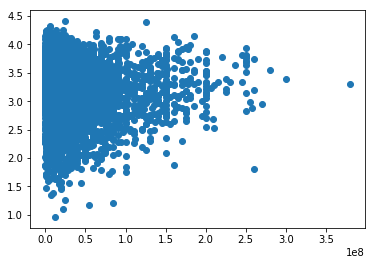

In [272]:
plt.scatter(movies_metadata_eda[movies_metadata_eda.budget>0].budget, movies_metadata_eda[movies_metadata_eda.budget>0].rating);

Now let's take a look at other variable that doesn't seem to be important but still could have something interesting: runtime.

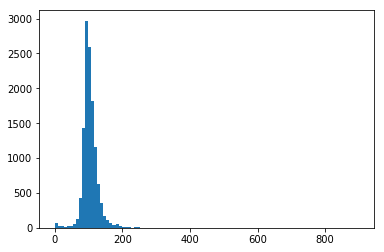

In [287]:
plt.hist(movies_metadata_eda.runtime, bins=100);

There seem to be some movies with weird runtimes (some of them really small and others really big, like 800 minutes), probably this needs more cleaning. For now let's have a look at the ones with a runtime shorter than 200.

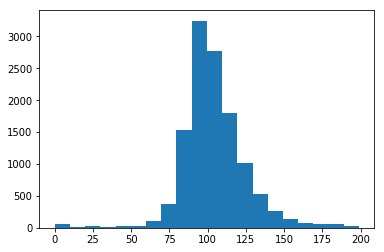

In [283]:
plt.hist(movies_metadata_eda[movies_metadata_eda.runtime<200].runtime, bins=20);

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


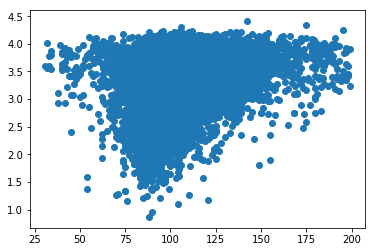

In [294]:
plt.scatter(movies_metadata_eda[movies_metadata_eda.runtime<200][movies_metadata_eda.runtime>30].runtime, movies_metadata_eda[movies_metadata_eda.runtime<200][movies_metadata_eda.runtime>30].rating);


Now I'll proceed to do some EDA on the movies overviews, for this I'll do NLP to create wordclouds and visualize the words that are more common in each categorie (in this case the 'categories' will be different ratings). For this I need to get all the movie summaries of each subcategory that I create together as one strin (for example, putting all the summaries of the movies with a rating higher than 4, or of the movies belonging to the 'Action' category. To not make this too long, I'll only do it for the movies with a high average rating (rating greater than 4), movies with a low average rating (smaller than 2) and movies belonging to two opposite categories (crime vs family).

First, I'll create the string with all the summaries of each subcategory together and then do the wordclouds.

In [67]:
text_rating_high = " ".join(ov for ov in movies_metadata_eda[movies_metadata_eda.rating>4].overview)
text_rating_low = " ".join(ov for ov in movies_metadata_eda[movies_metadata_eda.rating<2].overview)
text_movie_family = " ".join(ov for ov in movies_metadata_eda[movies_metadata_eda.Family==1].overview)
text_movie_crime = " ".join(ov for ov in movies_metadata_eda[movies_metadata_eda.Crime==1].overview)

Now I'll generate the wordclouds.

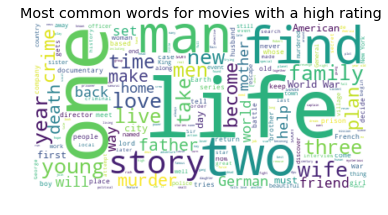

In [59]:
#High rating:

sw = set(STOPWORDS)
sw.update(["", "film", "movie"])

wordcloud_rating_high = WordCloud(stopwords=sw, background_color="white").generate(text_rating_high)

plt.imshow(wordcloud_rating_high, interpolation='bilinear')
plt.axis("off")
plt.title('Most common words for movies with a high rating', fontsize='x-large')
plt.show()

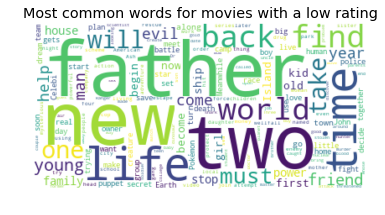

In [61]:
#Low rating:
wordcloud_rating_low = WordCloud(stopwords=sw, background_color="white").generate(text_rating_low)

plt.imshow(wordcloud_rating_low, interpolation='bilinear')
plt.axis("off")
plt.title('Most common words for movies with a low rating', fontsize='x-large')
plt.show()

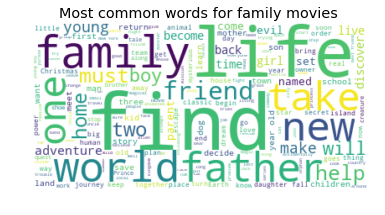

In [64]:
#Family movies
wordcloud_movie_family = WordCloud(stopwords=sw, background_color="white").generate(text_movie_family)

plt.imshow(wordcloud_movie_family, interpolation='bilinear')
plt.axis("off")
plt.title('Most common words for family movies ', fontsize='x-large')
plt.show()

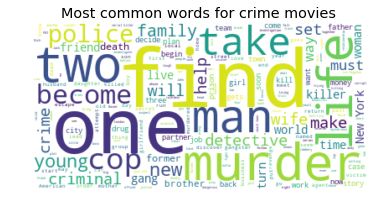

In [65]:
#Crime movies
wordcloud_movie_crime = WordCloud(stopwords=sw, background_color="white").generate(text_movie_crime)

plt.imshow(wordcloud_movie_crime, interpolation='bilinear')
plt.axis("off")
plt.title('Most common words for crime movies ', fontsize='x-large')
plt.show()

We can see some difference between the wordclouds of the family and crime movies but not a big difference between the high and low ratings movies, mainly because this summary is just a small preview of the movie. This is not bad for the project, as I won't be predicting ratings and these summaries can be used to classify the movies in a new way and improve the existing classification (movies categories).

### EDA report

This EDA has been explained step by step in this document, and gives me a clearer idea of the data that I have. It confirmed my idea of using the movies summaries to further classify the data and also made me notice that there is still potentially more cleaning to do. 

For my next steps, I'll finish cleaning the data and then finally start modelling the recommender system. First I'll do a simple system with only the ratings and then I'll try to improve it introducing other features.

# Modelling
<a id="modelling"></a>

### Collaborative filtering algorithms: User-based and item based

On this section I'll try user-based collaborative filtering algorithms, which take into account the ratings given by users to recommend movies. It finds users with similar preferences (similar ratings) and makes recommendations based on that. For example, if two users who have similar ratings patterns but there's a movie that user A liked and user B hasn't watched, it will recommend that movie to user B.

I'll first run a SVD algorithm with the default parameters setting to see how it performs.

In [34]:
n_users = filtered_ratings.userId.nunique()
n_movies = filtered_ratings.movieId.nunique()

In [35]:
import surprise as sur

reader = sur.Reader(rating_scale=(1, 5))
data_1 = sur.Dataset.load_from_df(filtered_ratings[['userId', 'movieId', 'rating']], reader)

In [17]:
algo = sur.SVD()

In [18]:
sur.model_selection.cross_validate(algo, data_1, measures=['RMSE', 'MAE'], cv=5)

{'test_rmse': array([0.76599546, 0.76611876, 0.76512302, 0.76547016, 0.76586225]),
 'test_mae': array([0.58109782, 0.58100372, 0.58040904, 0.58049099, 0.58077619]),
 'fit_time': (1132.452671289444,
  1132.568860054016,
  1195.8441541194916,
  1170.216731786728,
  1110.2510108947754),
 'test_time': (104.88805913925171,
  100.53733205795288,
  71.73781108856201,
  98.63192200660706,
  81.60649394989014)}

Running this model took a reaaally long time (103 minutes) but the results look good, specially for being the first one and only with the users ratings (collaborative filtering). Now I'll try gridsearch to improve it. First I'll do a train-test split and then run the gridsearch with the SVD algorithm and then the SVD++, which should be better (I tried the gridsearch with the whole data and the kernel died, so now I'll first make subsamples to do the initial modelling on smaller datasets).

In [9]:
filtered_ratings.head(2)

,userId,movieId,rating,timestamp,users_count,movies_count
0,11,110,3.5,1231676989,226,50854
1,24,110,5.0,979870012,634,50854


In [10]:
filtered_ratings.shape

(22602200, 6)

In [28]:
n_users

103669

In [29]:
n_movies

12341

In [26]:
sorted(list(filtered_ratings.users_count.unique()), reverse=True)[:10]

[7435, 6962, 6873, 6013, 5587, 5528, 5262, 5160, 4941, 4820]

In [27]:
sorted(list(filtered_ratings.movies_count.unique()), reverse=True)[:10]

[65614, 63909, 61132, 60177, 59048, 56423, 55766, 50854, 50768, 50366]

In [36]:
smaller_ratings = filtered_ratings[(filtered_ratings.movies_count>5000)&(filtered_ratings.users_count>150)]
smaller_ratings.drop(columns=['users_count','movies_count'], inplace=True)
print('shape: ', smaller_ratings.shape)
print('number of users: ', smaller_ratings.userId.nunique())
print('number of movies: ', smaller_ratings.movieId.nunique())

shape:  (10469416, 4)
number of users:  43591
number of movies:  1147


In [37]:
ratings_sample = smaller_ratings.sample(frac=0.3, random_state=1)
print('shape: ', ratings_sample.shape)
print('number of users: ', ratings_sample.userId.nunique())
print('number of movies: ', ratings_sample.movieId.nunique())

shape:  (3140825, 4)
number of users:  43591
number of movies:  1147


In [48]:
ratings_sample.head()

,userId,movieId,rating,timestamp
10806065,52404,1278,4.5,1143593695
9775730,228540,1320,4.0,1112300626
1380757,178546,457,3.0,859763279
4534716,259156,589,3.5,1172921202
13279705,96738,6365,3.0,1461971401


In [53]:
ratings_sample.userId.value_counts(ascending=True)[:10]

79659     3
22874     4
179073    4
43766     5
265210    5
68664     7
268670    8
185059    8
216794    8
44495     9
Name: userId, dtype: int64

In [38]:
reader = sur.Reader(rating_scale=(1, 5))
data_2 = sur.Dataset.load_from_df(ratings_sample[['userId', 'movieId', 'rating']], reader)

In [39]:
import random

raw_ratings2 = data_2.raw_ratings
np.random.seed(1)
random.shuffle(raw_ratings2)

threshold = int(.9 * len(raw_ratings2))
A_raw_ratings2 = raw_ratings2[:threshold]
B_raw_ratings2 = raw_ratings2[threshold:]

print(len(A_raw_ratings2))
print(len(B_raw_ratings2))

data_2.raw_ratings2 = A_raw_ratings2  

2826742
314083


In [40]:
print('Grid Search...')
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005]}
grid_search = sur.model_selection.GridSearchCV(sur.SVD, 
                                               param_grid, 
                                               measures=['rmse'], 
                                               cv=3,
                                               refit=True,
                                               n_jobs=-1,
                                               joblib_verbose=1)
grid_search.fit(data_2)

algo = grid_search.best_estimator['rmse']

trainset2 = data_2.build_full_trainset()
algo.fit(trainset2);

trainset_build2 = trainset2.build_testset()
predictions_train2 = algo.test(trainset_build2)
print('Training score ', end='   ')
sur.accuracy.rmse(predictions_train2)

testset2 = data_2.construct_testset(B_raw_ratings2)  # testset is now the set B
predictions_test2 = algo.test(testset2)
print('Test score (rated items) ', end=' ')
sur.accuracy.rmse(predictions_test2)

no_ratings2 = trainset2.build_anti_testset()
predictions_no_ratings2 = algo.test(no_ratings2)
print('Test score (unrated items) ', end='   ')
sur.accuracy.rmse(predictions_no_ratings2,verbose=True)

Grid Search...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:  1.8min remaining:  9.2min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  8.2min finished


Training score    RMSE: 0.7698
Test score (rated items)  RMSE: 0.7684
Test score (unrated items)    RMSE: 0.5695


0.5694796554587469

In [156]:
# Select your best algo with grid search. INTENTO CON SUBSET y SVD++
print('Grid Search...')
param_grid = {'n_factors': [20,30],'n_epochs': [10,20], 'lr_all': [0.002, 0.005, 0.007]}
grid_search = sur.model_selection.GridSearchCV(sur.SVDpp, 
                                               param_grid, 
                                               measures=['rmse'], 
                                               cv=3,
                                               refit=True,
                                               n_jobs=-1,
                                               joblib_verbose=1)
grid_search.fit(data_2)

algo = grid_search.best_estimator['rmse']

# retrain on the whole set A
trainset2 = data_2.build_full_trainset()
algo.fit(trainset2);

# Compute score on training set
trainset_build2 = trainset2.build_testset()
predictions_train2 = algo.test(trainset_build2)
print('Training score ', end='   ')
sur.accuracy.rmse(predictions_train2)

# Compute score on rated test set
testset2 = data_2.construct_testset(B_raw_ratings2)  # testset is now the set B
predictions_test2 = algo.test(testset2)
print('Test score (rated items) ', end=' ')
sur.accuracy.rmse(predictions_test2)

# Compute score on unrated data
# The anti-test set is the part where we did not have any ratings
no_ratings2 = trainset2.build_anti_testset()
predictions_no_ratings2 = algo.test(no_ratings2)
print('Test score (unrated items) ', end='   ')
sur.accuracy.rmse(predictions_no_ratings2,verbose=True)

Grid Search...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 188.3min finished


Training score    RMSE: 0.6880
Test score (rated items)  RMSE: 0.6798
Test score (unrated items)    RMSE: 0.6730


0.6730256638626748

The SVD++ algorithm performed better with a RMSE of 0.67 in the test set, which is good considering that the values are between 1 and 5 and also is really good when comparing it to the RMSE of other recommender systems that also use the MovieLens dataset.

In [157]:
grid_search.best_params

{'rmse': {'n_factors': 20, 'n_epochs': 20, 'lr_all': 0.007}}

In [158]:
print(len(trainset_build2), len(testset2), len(no_ratings2))

3140825 314083 46858052


We have the predictions but this predictions are in decimal numbers between 1 and 5 (for example, a predicted rating can be 3.74) whereas the actual ratings go from 0.5 to 0.5 (1 - 1.5 - 2 - 2.5 - ...), so we can round the predicted ratings to the closest half/integer number. First I'll create a DataFrame wit the predictions and define a function to make the change. (This is only to visually compare the predictions with the real ratings, the RMSE was calculated with the actual predicted values).

In [45]:
def rounder(number):
    r = round(number*2)/2
    return r

In [52]:
print(rounder(2.13))
print(rounder(2.33))
print(rounder(2.63))
print(rounder(2.98))

2.0
2.5
2.5
3.0


In [171]:
pred_train2.head(2)

,uid,iid,r_ui,est,details
0,252824,1370,4.0,3.5,{'was_impossible': False}
1,252824,2002,2.0,3.0,{'was_impossible': False}


In [161]:
pred_train2 = pd.DataFrame(predictions_train2)

In [162]:
pred_train2.est = pred_train2['est'].apply(rounder)

In [176]:
pred_test2 = pd.DataFrame(predictions_test2)
pred_test2.est = pred_test2['est'].apply(rounder)

In [178]:
pred_norating2 = pd.DataFrame(predictions_no_ratings2)
pred_norating2.est = pred_norating2['est'].apply(rounder)

In [184]:
pred_train2.iloc[30:35]

,uid,iid,r_ui,est,details
30,252824,1200,4.0,4.0,{'was_impossible': False}
31,252824,2000,4.0,3.5,{'was_impossible': False}
32,252824,25,4.0,3.5,{'was_impossible': False}
33,252824,1196,2.0,4.0,{'was_impossible': False}
34,252824,2641,3.0,3.0,{'was_impossible': False}


In [188]:
pred_test2.iloc[10:15]

,uid,iid,r_ui,est,details
10,203975,30707,4.0,4.0,{'was_impossible': False}
11,3792,4027,5.0,4.0,{'was_impossible': False}
12,235936,2288,4.5,4.0,{'was_impossible': False}
13,44217,1831,3.0,3.0,{'was_impossible': False}
14,241011,2115,5.0,4.0,{'was_impossible': False}


In [189]:
pred_norating2.iloc[155:160]   #here the r_ui is the average rating.

,uid,iid,r_ui,est,details
155,252824,1380,3.587227,3.0,{'was_impossible': False}
156,252824,2502,3.587227,3.5,{'was_impossible': False}
157,252824,4235,3.587227,3.5,{'was_impossible': False}
158,252824,3450,3.587227,3.0,{'was_impossible': False}
159,252824,1179,3.587227,3.5,{'was_impossible': False}


Looking at the RMSE and comparing some of the predicted ratings vs the real values we can see that the model did a pretty good job in predicting ratings based only on ratings. Now I'll try another algorithm, Slope One, which is item based (different from SVD that is user based).

In [231]:
algo = sur.SlopeOne()

algo.fit(trainset2)
predictions_train3 = algo.test(trainset_build2)
print('Biased accuracy on A,', end='   ')
sur.accuracy.rmse(predictions_train3)

predictions_test3 = algo.test(testset2)
print('Unbiased accuracy on B,', end=' ')
sur.accuracy.rmse(predictions_test2)

Biased accuracy on A,   RMSE: 0.8218
Unbiased accuracy on B, RMSE: 0.6798


0.6797736098850461

In [100]:
print(predictions_train3[5])
print(predictions_train3[300])
print(predictions_train3[2000])
print('\n')
print(predictions_test3[2])
print(predictions_test3[338])
print(predictions_test3[3994])

user: 1346       item: 2762       r_ui = 3.50   est = 3.84   {'was_impossible': False}
user: 5765       item: 1240       r_ui = 4.00   est = 3.99   {'was_impossible': False}
user: 6294       item: 2692       r_ui = 4.00   est = 4.40   {'was_impossible': False}


user: 172276     item: 6365       r_ui = 3.00   est = 3.17   {'was_impossible': False}
user: 111857     item: 379        r_ui = 2.00   est = 2.25   {'was_impossible': False}
user: 263426     item: 762        r_ui = 2.50   est = 2.00   {'was_impossible': False}


Now let's try another one, KNN With Means (It didn't run, tried the KNN Baseline but also didn't run).

In [242]:
algo = sur.KNNWithMeans()

algo.fit(trainset2)
predictions_train4 = algo.test(trainset_build2)
print('Biased accuracy on A,', end='   ')
sur.accuracy.rmse(predictions_train4)

predictions_test4 = algo.test(testset2)
print('Unbiased accuracy on B,', end=' ')
sur.accuracy.rmse(predictions_test4)

predictions_no_ratings4 = algo.test(no_ratings2)
print('Biased accuracy on C,', end='   ')
sur.accuracy.rmse(predictions_no_ratings4,verbose=False)

Computing the msd similarity matrix...
Done computing similarity matrix.


KeyboardInterrupt: 

### Precision@k and Recall@k


Now I'll use precision@k and recall@k to evaluate the best model.

In [191]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    f1s = dict()
    for uid, user_ratings in user_est_true.items():

        user_ratings.sort(key=lambda x: x[0], reverse=True)

        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

        # F1@K:
        f1s[uid] = 2*precisions[uid]*recalls[uid]/(precisions[uid]+recalls[uid]) if (precisions[uid]+recalls[uid]) != 0 else 1
    
    return precisions, recalls, f1s

In [240]:
#Train with k=5,20,50:

precisions, recalls, f1s = precision_recall_at_k(predictions_train2, k=5, threshold=4)
print('K=5:', end='\n')
print(np.mean(list(precisions.values())))
print(np.mean(list(recalls.values())))
print(np.mean(list(f1s.values())))

precisions, recalls, f1s = precision_recall_at_k(predictions_train2, k=20, threshold=4)
print('K=20:', end='\n')
print(np.mean(list(precisions.values())))
print(np.mean(list(recalls.values())))
print(np.mean(list(f1s.values())))

precisions, recalls, f1s = precision_recall_at_k(predictions_train2, k=50, threshold=4)
print('K=50:', end='\n')
print(np.mean(list(precisions.values())))
print(np.mean(list(recalls.values())))
print(np.mean(list(f1s.values())))

K=5:
0.9436187133429683
0.1272881961307565
0.22130058072979872
K=20:
0.9095622058217202
0.336126825251807
0.4603514700309201
K=50:
0.8941084272147155
0.43646151400723937
0.5391009884325597


In [241]:
#Test with k=5,20,50:

precisions, recalls, f1s = precision_recall_at_k(predictions_test2, k=5, threshold=4)
print('K=5:', end='\n')
print(np.mean(list(precisions.values())))
print(np.mean(list(recalls.values())))
print(np.mean(list(f1s.values())))

precisions, recalls, f1s = precision_recall_at_k(predictions_test2, k=20, threshold=4)
print('K=20:', end='\n')
print(np.mean(list(precisions.values())))
print(np.mean(list(recalls.values())))
print(np.mean(list(f1s.values())))

precisions, recalls, f1s = precision_recall_at_k(predictions_test2, k=50, threshold=4)
print('K=50:', end='\n')
print(np.mean(list(precisions.values())))
print(np.mean(list(recalls.values())))
print(np.mean(list(f1s.values())))

K=5:
0.9249550154839408
0.484366270244137
0.560439918845962
K=20:
0.9221740488531149
0.5060703152100652
0.5744371016580171
K=50:
0.9221727204666356
0.5060936155890047
0.5744498162928826


In [234]:
#Test (Slope One Model):

precisions, recalls, f1s = precision_recall_at_k(predictions_test3, k=5, threshold=4)

print(np.mean(list(precisions.values())))
print(np.mean(list(recalls.values())))
print(np.mean(list(f1s.values())))

0.8894288317926619
0.38342651388612925
0.46187363635187134


Looking at the precision@k and recall@k I can conclude some things:

 - Confirm that the SVD++ performs better than the Slope One
 - The Precision scores are good, the recall ones not so much
 - The Recall improves and Precision slightly decays with a bigger K.
 
This happens because Precision@K is definded as the number of relevant items recommended out of all the recommended (being 'relevant' the ones with a predicted rating above a threshold, 3.5 in this case) and Recall@K as the number of relevant items recommended out of all the relevant ones, so if I only recommend few movies, or calculate the Recall with a low K, the Recall@K will be low.

In [194]:
from collections import defaultdict

def get_top_predictions(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, true_r, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[2], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [195]:
top_predictions = get_top_predictions(predictions_test2, n=10)

In [196]:
len(top_predictions.keys())

43163

In [197]:
top_predictions_list = []
for k in top_predictions.keys():
    for v in top_predictions[k]:
        top_predictions_list.append([k,v[0],v[1],v[2]])
        
df_top = pd.DataFrame(top_predictions_list,columns=['userId','movieId','true_rating','est_rating'])
df_top.head(5)

,userId,movieId,true_rating,est_rating
0,42146,4973,5.0,4.982750
1,42146,1198,5.0,4.486837
2,42146,3168,4.0,4.336480
3,42146,1967,4.0,4.207494
4,42146,2302,3.5,4.122087


In [198]:
df_top[df_top.userId==3571][3:7][['movieId', 'true_rating', 'est_rating']]

,movieId,true_rating,est_rating
121134,8368,3.0,3.142355
121135,597,3.0,2.858956
121136,48,3.0,2.510937
121137,208,2.0,2.172456


That looks good, but it would be better to also include the names of the movies (instead of only the movie id). For this I need to get the name from the movies_metadata and merge it using the links dataframe.

In [80]:
link_with_title = pd.merge(links,movies_metadata_eda[['imdb_id','full_title']],left_on='imdbId', right_on='imdb_id',how='inner', sort=False)

In [81]:
link_with_title.head()

,movieId,imdbId,tmdbId,imdb_id,full_title
0,1,114709,862.0,114709,Toy Story 1995
1,2,113497,8844.0,113497,Jumanji 1995
2,3,113228,15602.0,113228,Grumpier Old Men 1995
3,4,114885,31357.0,114885,Waiting to Exhale 1995
4,5,113041,11862.0,113041,Father of the Bride Part II 1995


In [82]:
def get_name(movieid):
    name = (list(link_with_title[link_with_title.movieId==movieid].full_title))[0]
    return name

In [199]:
def user_recommendations(user_id,n_preds):
    len_up = len(df_top[df_top.userId==user_id])
    if n_preds<=10: 
        recom = df_top[df_top.userId==user_id][:n_preds][['movieId', 'est_rating']]
        recom['movie_name'] = recom.movieId.map(lambda x: get_name(x))
        if n_preds<=len_up:
            print(recom)
        else:
            print('User',user_id,'only has',len_up,'recommendations:','\n')
            print(recom)
    if n_preds>10:
        recom = df_top[df_top.userId==user_id][['movieId', 'est_rating']]
        recom['movie_name'] = recom.movieId.map(lambda x: get_name(x))
        if len_up==10:
            print('Showing top 10 recommendations:')
            print(recom)
        else:
            print('User',user_id,'has only',len_up,'recommendations:','\n')
            print(recom)
            
            


Let's try this recommendator with some users:

In [200]:
user_recommendations(20575,10)

User 20575 only has 9 recommendations: 

        movieId  est_rating                                          movie_name
182279    40819    4.275501                                  Walk the Line 2005
182280     7153    4.194141  The Lord of the Rings: The Return of the King 2003
182281      474    4.092284                            In the Line of Fire 1993
182282    55765    3.922610                              American Gangster 2007
182283     3911    3.867525                                   Best in Show 2000
182284     6863    3.820668                                 School of Rock 2003
182285     1407    3.689481                                         Scream 1996
182286     2012    3.639716                    Back to the Future Part III 1990
182287     1527    3.512334                              The Fifth Element 1997


In [201]:
user_recommendations(3571,5)

        movieId  est_rating                                     movie_name
121131     2700    3.643042        South Park: Bigger, Longer & Uncut 1999
121132     3087    3.381686                                  Scrooged 1988
121133     2915    3.197360                            Risky Business 1983
121134     8368    3.142355  Harry Potter and the Prisoner of Azkaban 2004
121135      597    2.858956                              Pretty Woman 1990


**The next two cells are the ones that I tried running first with all the data, I'm currently not using them but maybe later I'll try again.**

In [19]:
import random

raw_ratings = data_1.raw_ratings
np.random.seed(1)
# shuffle ratings if you want
random.shuffle(raw_ratings)

# A = 90% of the data, B = 10% of the data
threshold = int(.9 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

print(len(A_raw_ratings))
print(len(B_raw_ratings))

data_1.raw_ratings = A_raw_ratings  # data is now the set A

20341980
2260220


In [ ]:
print('Grid Search...')
param_grid = {'n_factors': [20],'n_epochs': [20], 'lr_all': [0.007, 0.009]}
#grid_search = sur.model_selection.GridSearchCV(sur.SVDpp, 
                                               param_grid, 
                                               measures=['rmse'], 
                                               cv=3,
                                               refit=True,
                                               n_jobs=-1,
                                               joblib_verbose=1)
#grid_search.fit(data_1)

#algo = grid_search.best_estimator['rmse']


#trainset = data_1.build_full_trainset()
#algo.fit(trainset);


#trainset_build = trainset.build_testset()
#predictions_train = algo.test(trainset_build)
print('Training score ', end='   ')
#sur.accuracy.rmse(predictions_train)


#testset = data_1.construct_testset(B_raw_ratings)  # testset is now the set B
#predictions_test = algo.test(testset)
print('Test score (rated items) ', end=' ')
#sur.accuracy.rmse(predictions_test)


# The anti-test set is the part where we did not have any ratings
#no_ratings = trainset.build_anti_testset()
#predictions_no_ratings = algo.test(no_ratings)
print('Test score (unrated items) ', end='   ')
#sur.accuracy.rmse(predictions_no_ratings,verbose=False)

Grid Search...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarni

Training score    RMSE: 0.7431
Test score (rated items)  RMSE: 0.7835


### Content based: movies similarity

Now I'll build a model that recommends similar movies to the ones liked. For this I'll use the information from the movies_metadata_eda (only 12,000 movies instead of 45,000 from the original movies_metadata, this due to computational power and also to only keep well-known movies), keywords and credits(actors and director) dataframes.

In [86]:
used_movies = movies_metadata_eda['id']

In [87]:
small_credits = credits[credits['id'].isin(used_movies)]

In [88]:
small_keywords = keywords[keywords['id'].isin(used_movies)]

First I'll try a model using only the overview and tagline of each movie (from the movies_metadata_eda dataframe), and then improve it including the credits and keywords. For this, I'll create a new column that consist on the text of the overview and the tagline and then run a tf-idf vectorizer to calculate the cosine similarity.

In [89]:
movies_metadata_eda['tagline'].fillna('', inplace=True)

In [90]:
movies_metadata_eda['movie_description'] = movies_metadata_eda['overview'] + movies_metadata_eda['tagline']
movies_metadata_eda['movie_description'].fillna('', inplace=True)

In [91]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies_metadata_eda['movie_description'])
tfidf_matrix.shape

(12331, 348982)

In [92]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

Now that I have the cosine similarity matrix, the next step is to extract the most similar movies to any movie we choose.

In [93]:
movies_metadata_eda.reset_index(inplace=True)
titles = movies_metadata_eda['full_title']
indices = pd.Series(movies_metadata_eda.index, index=movies_metadata_eda['full_title'])

In [94]:
def get_n_similar_movies(title, n):
    indx = indices[title]
    sim_scores = list(enumerate(cosine_sim[indx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [95]:
get_n_similar_movies('Toy Story 1995',10)

2773                Toy Story 2 1999
9991                Toy Story 3 2010
7953     The 40 Year Old Virgin 2005
11549                 Small Fry 2011
2825            Man on the Moon 1999
8601               Factory Girl 2006
997       Rebel Without a Cause 1955
5691     What's Up, Tiger Lily? 1966
8482     For Your Consideration 2006
5192              Class of 1984 1982
Name: full_title, dtype: object

In [96]:
get_n_similar_movies('The Godfather: Part II 1974',5)

768                The Godfather 1972
1762     The Godfather: Part III 1990
15                        Casino 1995
10581           Hostel: Part III 2011
1424                   Star Maps 1997
Name: full_title, dtype: object

In [97]:
get_n_similar_movies('Zombieland 2009',3)

7884    Land of the Dead 2005
9925            Kick-Ass 2010
5796     Day of the Dead 1985
Name: full_title, dtype: object

This seems to do a relatively good job, but now I'll try to improve it including the category, keywords, cast (top 3 actors) and director. But first, some pre-processing.

In [98]:
movies_metadata_full = pd.merge(movies_metadata_eda, small_credits, how='inner', on='id')
movies_metadata_full = pd.merge(movies_metadata_full, small_keywords, how='inner', on='id')

In [99]:
movies_metadata_full['cast'] = movies_metadata_full['cast'].apply(literal_eval)
movies_metadata_full['crew'] = movies_metadata_full['crew'].apply(literal_eval)
movies_metadata_full['keywords'] = movies_metadata_full['keywords'].apply(literal_eval)
movies_metadata_full['cast_size'] = movies_metadata_full['cast'].apply(lambda x: len(x))

In [100]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
        return np.nan

In [101]:
movies_metadata_full['director'] = movies_metadata_full['crew'].apply(get_director)
movies_metadata_full.drop(columns=['crew'], inplace=True)

Now I have the director of each movie (extracted from 'crew'), next step will be extracting the top 3 actors. For this I'll first get a list with the names of the actors and then choose the first 3. As the cast is a dictionary, I'll extract the value from the 'name' key.

In [102]:
movies_metadata_full['cast'] = movies_metadata_full['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_metadata_full['cast'] = movies_metadata_full['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

As the model will evaluate the words, it is a good idea to turn all letters to lower case and remove the space between firs and last names to get unique words for each person. Another thing I'll do is include 3 times the name of the director to give it more weight, as I consider the director as someone importan when measuring the quality of a movie and also users may have preferences for directors so it would be good to consider as 'similar' two movies from the same director.

In [103]:
movies_metadata_full['cast'] = movies_metadata_full['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
movies_metadata_full['director'] = movies_metadata_full['director'].astype(str).apply(lambda x: str.lower(x.replace(" ", "")))
movies_metadata_full['director'] = movies_metadata_full['director'].apply(lambda x: [x,x,x])


Now some keywords pre-processing. First, extracting the keyword (it is inside a dictionary) and calculating the frequency of each keyword to only keep the ones that appear more than once.


In [104]:
movies_metadata_full['keywords'] = movies_metadata_full['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [105]:
kw = movies_metadata_full.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
kw.name= 'keyword'

In [106]:
kw = kw.value_counts()
kw[:10]

independent film        880
woman director          829
murder                  533
based on novel          440
duringcreditsstinger    390
violence                338
sex                     313
love                    292
suspense                286
revenge                 279
Name: keyword, dtype: int64

In [107]:
kw = kw[kw>1]

To improve the model, I'll use a stemmer so similar words (with the same root) are considered the same (e.g. 'toy' and 'toys') and also filter the keywords to only keet the ones in 'kw' (the ones that appear more than once).

In [108]:
stemmer = SnowballStemmer('english')

In [109]:
def filter_kw(x):
    words = []
    for i in x:
        if i in kw:
            words.append(i)
    return words

In [110]:
movies_metadata_full['keywords'] = movies_metadata_full['keywords'].apply(filter_kw)
movies_metadata_full['keywords'] = movies_metadata_full['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
movies_metadata_full['keywords'] = movies_metadata_full['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

For the genres, I'll extract the genre name from the genre column (genre name was in a dictionary, similar to keywords and cast)

In [111]:
movies_metadata_full['genres'] = movies_metadata_full['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

Now that I have all the information needed ready I'll put it together. As some of the columns are strings and others lists, I'll transform the lists into strings.

In [112]:
def list_to_str(l):
    if type(l)==list:
        w = ''
        for i in range(len(l)):
            w = w+l[i]+' '
        return w
    else: 
        return l

In [113]:
movies_metadata_full['cast'] = movies_metadata_full['cast'].apply(list_to_str)
movies_metadata_full['keywords'] = movies_metadata_full['keywords'].apply(list_to_str)
movies_metadata_full['genres'] = movies_metadata_full['genres'].apply(list_to_str)
movies_metadata_full['director'] = movies_metadata_full['director'].apply(list_to_str)

In [114]:
movies_metadata_full['all_together'] = movies_metadata_full['director']+movies_metadata_full['keywords']+movies_metadata_full['movie_description']+movies_metadata_full['cast']+movies_metadata_full['genres']


In [209]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(movies_metadata_full['all_together'])

In [214]:
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

Now, to get recommendations/similar movies I need a function similar to the one used before. Finally, I'll be able to test it with the same movies and see if it improved.

In [ ]:
movies_metadata_full.reset_index(inplace=True)

In [119]:
titles2 = movies_metadata_full['full_title']
indices2 = pd.Series(movies_metadata_full.index, index=movies_metadata_full['full_title'])

In [215]:
def get_n_similar_movies_improved(title, n):
    indx = indices2[title]
    sim_scores = list(enumerate(cosine_sim2[indx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    movie_indices = [i[0] for i in sim_scores]
    sim_scores = [e[1] for e in sim_scores]
    d = {'Movie':titles2.iloc[movie_indices], 'Similarity Score': sim_scores}
    return pd.DataFrame(data=d)

In [216]:
get_n_similar_movies_improved('Toy Story 1995',10)

,Movie,Similarity Score
2833,Toy Story 2 1999,0.269567
10195,Toy Story 3 2010,0.227019
10939,Tin Toy 1988,0.170400
10948,Red's Dream 1987,0.150278
8326,Luxo Jr. 1986,0.147745
10562,Cars 2 2011,0.146481
10955,Knick Knack 1989,0.143857
11523,Mater and the Ghostlight 2006,0.135932
8133,The 40 Year Old Virgin 2005,0.130959
11777,Small Fry 2011,0.111838


In [217]:
get_n_similar_movies_improved('The Godfather: Part II 1974',5)

,Movie,Similarity Score
1810,The Godfather: Part III 1990,0.313248
792,The Godfather 1972,0.235897
2227,Peggy Sue Got Married 1986,0.179016
5681,Dementia 13 1963,0.148082
1900,The Outsiders 1983,0.147411


In [218]:
get_n_similar_movies_improved("Schindler's List 1993", 5)

,Movie,Similarity Score
9333,The Rape of Europa 2006,0.249291
3693,Empire of the Sun 1987,0.212740
4455,Midway 1976,0.208842
6525,Soldier of Orange 1977,0.204174
9572,Defiance 2008,0.204057


In [219]:
get_n_similar_movies_improved("Forrest Gump 1994", 10)

,Movie,Similarity Score
9041,Feast of Love 2007,0.160132
375,Jason's Lyric 1994,0.153624
12510,Allied 2016,0.151895
2477,Jules and Jim 1962,0.151319
12145,The Walk 2015,0.150349
2030,About Last Night... 1986,0.145873
9146,Dedication 2007,0.140467
274,Only You 1994,0.139416
7697,Kal Ho Naa Ho 2003,0.138296
2715,Who Framed Roger Rabbit 1988,0.137799


In [220]:
get_n_similar_movies_improved("Gladiator 2000", 10)

,Movie,Similarity Score
84,White Squall 1996,0.115787
11801,Exodus: Gods and Kings 2014,0.109438
11653,Hercules 2014,0.103937
1446,G.I. Jane 1997,0.100462
7689,In Hell 2003,0.095847
3076,Thelma & Louise 1991,0.089158
8992,The Last Legion 2007,0.087756
5328,The Duellists 1977,0.083585
4802,Behind the Sun 2001,0.082806
5681,Dementia 13 1963,0.082018


In [221]:
get_n_similar_movies_improved('Zombieland 2009', 10)

,Movie,Similarity Score
1340,Guantanamera 1995,0.273565
10197,Ricky Gervais Live 3: Fame 2007,0.257437
8643,Feast 2005,0.242174
7406,Theatre of Blood 1973,0.241701
8325,Richard Pryor: Live in Concert 1979,0.240275
7969,Tanguy 2001,0.233691
10803,Dylan Moran: Monster 2004,0.233691
11073,Cockneys vs Zombies 2012,0.232746
554,The Brady Bunch Movie 1995,0.232258
1488,A Smile Like Yours 1997,0.232258


In [228]:
get_n_similar_movies_improved("Ferris Bueller's Day Off 1986", 8)

,Movie,Similarity Score
1340,Guantanamera 1995,0.356869
10197,Ricky Gervais Live 3: Fame 2007,0.335830
5349,Chicago 2002,0.317063
7637,Run Ronnie Run 2002,0.315302
8325,Richard Pryor: Live in Concert 1979,0.313442
6742,Pursuit of Happiness 2001,0.309125
9798,The Imaginarium of Doctor Parnassus 2009,0.309125
8239,The Weather Man 2005,0.305888


### Hybrid Model

This far, I have two models: 
 - One that takes as input the rankings given by all users to movies and returns a list of recommended movies based on the estimated ratings.
 - One that takes as input one movie and, based on the information of all the movies, returns the most similar movies.
 
Now I'll try to implement a hybrid recommender system combining the two models I have. There are many ways of doing this, so I'll start with one that takes as an input a user id and a movie and, given that, returns similar movies but also with the estimated rating for each, so it'll be possible to rank them. Later I'll try different aproaches.

In [570]:
link_with_title.head()

,movieId,imdbId,tmdbId,imdb_id,full_title
0,1,114709,862.0,114709,Toy Story 1995
1,2,113497,8844.0,113497,Jumanji 1995
2,3,113228,15602.0,113228,Grumpier Old Men 1995
3,4,114885,31357.0,114885,Waiting to Exhale 1995
4,5,113041,11862.0,113041,Father of the Bride Part II 1995


In [127]:
link_title = link_with_title.set_index('full_title')

In [128]:
link_index = link_with_title.set_index('tmdbId')

In [129]:
svd = SVD(n_epochs=10)

In [130]:
trainset = data_2.build_full_trainset()
algo.train(trainset)

In [714]:
link_index.head(2)

,movieId,imdbId,imdb_id,full_title
tmdbId,,,,
862.0,1,114709,114709,Toy Story 1995
8844.0,2,113497,113497,Jumanji 1995


In [252]:
def hybrid_recommender(userId, title, n):
    idx = indices2[title]
    tmdbId = link_title.loc[title]['tmdbId']
    movie_id = link_title.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim2[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = movies_metadata_full.iloc[movie_indices][['full_title', 'rating', 'id']]
    movies['est'] = movies['id'].apply(lambda x: algo.predict(userId, link_index.loc[x]['movieId']).est)
    sim_scores = [e[1] for e in sim_scores]
    movies['similarity'] = sim_scores
    movies = movies.sort_values('est', ascending=False)
    return movies

In [273]:
hybrid_recommender(20575,'Pulp Fiction 1994', 5)

,full_title,rating,id,est,similarity
1031,Reservoir Dogs 1992,4.083528,500,4.599543,0.145393
9696,Inglourious Basterds 2009,3.991810,16869,4.345054,0.104235
6043,Kill Bill: Vol. 1 2003,3.857899,24,4.012406,0.150190
1567,Jackie Brown 1997,3.693612,184,3.959816,0.162393
11963,The Hateful Eight 2015,3.829401,273248,3.587227,0.194768


In [272]:
hybrid_recommender(20575,"Toy Story 1995", 5)

,full_title,rating,id,est,similarity
2833,Toy Story 2 1999,3.808074,863,5.000000,0.269567
10195,Toy Story 3 2010,3.869804,10193,4.181701,0.227019
10939,Tin Toy 1988,3.319149,13927,3.587227,0.170400
10948,Red's Dream 1987,3.245763,13926,3.587227,0.150278
8326,Luxo Jr. 1986,3.658333,13925,3.587227,0.147745


The model performs well, as for the same user but with different input movies it recommends different movies based on similarity and estimated rating.

### Next steps

The next hybrid model that I'll build will be one that will only take as input a user id and will work as follows:

 - Take a user id as input
 - Look for the user favourite movies (highest rated)
 - Get the top similar movies to those with highest user rating
 - Calculate the estimated ratings for those similar movies
 - Return the movies with the highest estimated rating
 
Then I'll try other aproaches to hybrid models.

Also, I'll try to use flask to create a nice looking page where recommendations can be given and try to do the side project I proposed at the begining (predict revenues/profit and try some classification methods to see how they perform and clustering to seek potential alternative categories).

# Technical Report
<a id="report"></a>

The objective of this project was to build a movies recommender system. I took three different approaches: the first one using collaborative filtering, the second one using movies similarities and the third one using a hybrid system combining the first two. As these models have different inputs and outputs, they have different metrics to evaluate them, being the most important RMSE and cosine similarity. I’ve been able to predict the ratings users would give to movies they haven’t watched and determine the similarity between movies, and this can be used to recommend movies to users. 

The data comes from the famous MovieLens dataset, which was extracted from the MovieLens webpage by GroupLens Research from the Department of Computer Science and Engineering at the University of Minnesota Twin Cities. The datasets used for this project consisted on the following information: user ratings to different movies and movies information. The main limitation has been computational power, as my ratings dataset, after data cleaning and pre-processing, consisted on 22 million user-movie combinations (≈ 102,000 users and 12,000 movies). This project has been done using a sample of only 3 million items, so one of my next steps will be to run the models with more data to get better results. From this problem derives the limitation of user recommendations: as not all the users are taken into account, I can’t recommend movies to some of them. Another limitation was that the information I had about movies wasn’t the best so, although I could calculate a good similarity score between movies, this could’ve been even better with better data.

Moving on deeply into the steps I undertook, in total I had 5 datasets: user ratings, movies metadata, movies keywords, movies crew (cast and production team) and links (to link the dataframes with different movie ids). My data cleaning and pre-processing was done using the first two, as those were the main ones for my models. Some of the steps I took in this part were dropping useless columns, changing data types, filling missing values with 0s, extracting features from columns (e.g. year from release date), creating new columns, etc. Also, I decided to only keep the users who had rated 50 or more movies and the movies that had received 50 or more ratings, because the ones with less ratings aren’t a good source of information (and also this way I could reduce the size of the dataset).

For the EDA, I explored the ratings distributions in different ways (ratings for each category, number of ratings by user/movie, etc.) and also did some NLP to compare the movies summaries of good vs bad movies. I discovered that there was a user who had rated more than 18,000 movies (that’s the equivalent to watching one movie per day for 50 years!) but then, reading online I found that this was actually true.

For the modelling section I used Surprise, a Python library for building and testing recommender systems. Before trying any models, to reduce fitting and testing times, I proceeded to further reduce the dataset by only keeping movies with more than 5000 ratings and users with more than 150 ratings. This reduced the dataset from 22 to 10 millions rows, meaning that it was still too big, so I decided to take a random sample of size 0.3 and proceeded to work with those 3.1 million items. Then I started the modelling. First I tried a collaborative-filtering approach, both user and item based. I started by using the famous SVD algorithm, the Slope One algorithm and the SVD++, being the grid search of the last one the one with best result (smallest RMSE, 0.679).  (Here I had many more models to try but, to not make it take too long, I used Surprise’s model performance comparison to choose which ones to try). 

With this model I proceeded to get the predicted ratings to visually compare them with the real ratings to get a taste of how well the model performed. As the model predicted values between 1 and 5 but the ratings went from 0.5 to 0.5, I decided to round the estimations to the nearest 0.5/1 (e.g. if a movie has a true rating of 4.5 and an estimated rating of 4.39, as it is impossible to rate a movie with 4.39, the estimated rating should be rounded to 4.5). This was only done for visualizing the results, as the RMSE was calculated with the original estimations.

Then I proceeded to calculate Precision@k and Recall@k. This helped me to confirm that the SVD++ performed better than the Slope One. Also, the Precision scores are good, and the recall ones not so much, while the Recall improves and Precision slightly decays with a bigger K. This happens because Precision@K is definded as the number of relevant items recommended out of all the recommended (being 'relevant' the ones with a predicted rating above a threshold, 3.5 in this case) and Recall@K as the number of relevant items recommended out of all the relevant ones, so if I only recommend few movies, or calculate the Recall with a low K, the Recall@K will be low. The final thing I did with this collaborative-filtering model was to create a function that would return the top n recommendations for a given user. 

The next section consisted on a content-based model that aimed to, given a movie as an input, recommend the most similar movies based on their characteristics. I first built one using the text from the movie overview and tagline and then improved it including also the top 3 actors, the director (3 times to give it more weight) the genre and the keywords. The output of this model was a DataFrame with the top n more similar movies and their corresponding cosine similarity score.

Finally, I tried to build a hybrid recommender system, one that could include the two previous models. There are many different approaches for this, so first I tried one that takes as an input a user id and a movie title and, based on that, recommends the top n similar movies but also with the predicted rating for each movie. This model isn’t optimized yet and I have to try different approaches, but for now that’s what I have. My next steps are to keep on working on the hybrid model and try to run the collaborative-filtering models in the whole dataset (or at least in bigger samples) to make it better. 

How and where could this model be applied in an enterprise environment? There are many ways of using this kind of models in real life and it doesn’t have to necessarily be with movies, some of them are very famous, such as Netflix, Amazon and YouTube. This could be used for any retailer of any kind that has information about the products and/or the users. Also, could be used for news recommendations, search queries, restaurants, financial services, etc.